# GAMEEMO × MSDCGTNet — **Stable & Fast**
• correct `[64 channels, time]` layout
• down‑sampled to 64 Hz
• single‑process DataLoader (Windows‑safe)
• batch 8, epochs finish in a couple of minutes on a GTX 2060


**Hot‑fix – 2025-05-14**

‑ Fixed `N_CHANNELS` mis‑assignment (now uses `sample.shape[1]`).
‑ Updated AMP API calls (deprecated `torch.cuda.amp.*` → `torch.amp.*`).

Run all cells from scratch.

## 1 Data discovery

In [1]:
# %% [code]
from pathlib import Path
import subprocess, sys

DATA_ROOT = Path("../data/GAMEEMO")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

if not any(DATA_ROOT.rglob("*.csv")):
    print("Downloading GAMEEMO")
    try:
        subprocess.run([
            "kaggle", "datasets", "download",
            "-d", "sigfest/database-for-emotion-recognition-system-gameemo",
            "-p", str(DATA_ROOT.parent), "--unzip",
        ], check=True)
    except Exception as e:
        sys.stderr.write(f"⚠️ Kaggle download failed: {e}\n")
else:
    print("Dataset already present - skipping download.")


Dataset already present - skipping download.


In [3]:
from pathlib import Path, re
import torch

DATA_ROOT = Path("../data/GAMEEMO")

def g_label(fn): return int(re.search(r"G([1-4])", fn).group(1)) - 1
eeg_paths, labels = [], []
for subj in DATA_ROOT.iterdir():
    if not subj.is_dir() or not re.fullmatch(r"\(S\d{2}\)", subj.name): continue
    csv_dir = subj / "Preprocessed EEG Data" / ".csv format"
    for p in csv_dir.glob("*.csv"):
        eeg_paths.append(p); labels.append(g_label(p.name))
print(f"Found {len(eeg_paths)} recordings")

# --- class weights for imbalanced data ---
from collections import Counter
cnt = Counter(labels)
counts = torch.tensor([cnt.get(i,0) for i in range(4)], dtype=torch.float32)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * 4
print("Class counts:", counts.tolist(), "→ weights:", class_weights.tolist())


Found 112 recordings
Class counts: [28.0, 28.0, 28.0, 28.0] → weights: [1.0, 1.0, 1.0, 1.0]


## 2 Dataset & DataLoaders

In [4]:
import pandas as pd, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

class GameEmoEEG(Dataset):
    """CSV → tensor [n_channels, time]  @64 Hz (down‑sampled)."""
    def __init__(self, paths, labels, ds=4):
        self.p, self.y, self.ds = paths, labels, ds
    def __len__(self):
        return len(self.p)
    def __getitem__(self, idx):
        df = (
            pd.read_csv(self.p[idx], header=None)
              .apply(pd.to_numeric, errors='coerce')
              .fillna(0.0)
        )
        x = torch.tensor(df.values.T, dtype=torch.float32)[:, :: self.ds]
        # per‑sample z‑score normalization (channel‑wise)
        x = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-6)
        return x, torch.tensor(self.y[idx], dtype=torch.long)

# --- subject‑wise split to avoid leakage ---
def _subject_from_path(p):
    # (S01) is 4th ancestor of CSV file: .../GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/file.csv
    for part in p.parts[::-1]:
        if part.startswith("(S") and part.endswith(")"):
            return part
    raise ValueError(f"Cannot parse subject from path: {p}")

subjects = [_subject_from_path(p) for p in eeg_paths]
unique_subj = sorted(set(subjects))
rng = np.random.default_rng(42)
rng.shuffle(unique_subj)
val_ratio = 0.2
n_val = max(1, int(len(unique_subj) * val_ratio))
val_subj = set(unique_subj[:n_val])

train_idx = [i for i, s in enumerate(subjects) if s not in val_subj]
test_idx  = [i for i, s in enumerate(subjects) if s in val_subj]

BATCH = 8  # little higher now that sample length is down‑sampled
train_loader = DataLoader(
    GameEmoEEG([eeg_paths[i] for i in train_idx], [labels[i] for i in train_idx]),
    batch_size=BATCH, shuffle=True, drop_last=True, num_workers=0,
)
test_loader = DataLoader(
    GameEmoEEG([eeg_paths[i] for i in test_idx], [labels[i] for i in test_idx]),
    batch_size=BATCH, num_workers=0,
)

sample, _ = next(iter(train_loader))
N_CHANNELS, N_CLASSES = sample.shape[1], 4  # channels count is dim 1
print('Sample shape:', sample.shape)

Sample shape: torch.Size([8, 15, 9564])


In [5]:
## Dataset sizes
print(f"Train set size: {len(train_loader.dataset):,} samples ({len(train_loader):,} batches)")
print(f"Val set size:   {len(test_loader.dataset):,} samples ({len(test_loader):,} batches)")


Train set size: 92 samples (11 batches)
Val set size:   20 samples (3 batches)


## 3 Model — MSDCGTNet

In [6]:
import torch.nn as nn, torch
class MSDCGTNet(nn.Module):
    def __init__(self, c_in, n_cls, d=64, heads=4, layers=2):
        super().__init__()
        self.c3 = nn.Conv1d(c_in, d, 3, 1, 1)
        self.c5 = nn.Conv1d(c_in, d, 5, 1, 2)
        self.c7 = nn.Conv1d(c_in, d, 7, 1, 3)
        self.bn = nn.BatchNorm1d(3 * d)
        self.act = nn.ReLU()
        self.reduce = nn.AvgPool1d(4, 4)        # ← NEW: 4× temporal shrink
        enc = nn.TransformerEncoderLayer(3 * d, heads, 4 * d, batch_first=True)
        self.tr = nn.TransformerEncoder(enc, layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(3 * d, n_cls)

    def forward(self, x):                       # x [B, C, T]
        x = torch.cat([self.c3(x), self.c5(x), self.c7(x)], 1)
        x = self.act(self.bn(x))
        x = self.reduce(x)                      #  <-- sequence length ÷ 4
        x = self.tr(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = MSDCGTNet(N_CHANNELS, N_CLASSES).to(device)

## 4 Training

In [7]:
## 4 Training — tuned hyper‑params + EarlyStopping + F1
import torch.nn.functional as F, torch.optim as optim, time
from sklearn.metrics import f1_score
from collections import deque

LR = 3e-4
WEIGHT_DECAY = 1e-3
EPOCHS = 30
PATIENCE = 5
CLIP_NORM = 1.0

opt = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=3)

class EarlyStopper:
    def __init__(self, patience):
        self.best = float('inf')
        self.patience = patience
        self.num_bad = 0
    def step(self, metric):
        if metric < self.best:
            self.best = metric
            self.num_bad = 0
            return False  # keep going
        else:
            self.num_bad += 1
            return self.num_bad > self.patience

stopper = EarlyStopper(PATIENCE)
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())  # mixed precision

def run(loader, train=True):
    model.train() if train else model.eval()
    tot = correct = loss_sum = 0.0
    all_pred, all_true = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            with torch.amp.autocast(enabled=torch.cuda.is_available(), device_type=device.type):
                out = model(x)
                loss = F.cross_entropy(out, y, weight=class_weights.to(device))
            if train:
                scaler.scale(loss).backward()
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
                scaler.step(opt)
                scaler.update()
        pred = out.argmax(1)
        all_pred.extend(pred.cpu().numpy())
        all_true.extend(y.cpu().numpy())
        correct += (pred == y).sum().item()
        loss_sum += loss.item() * y.size(0)
        tot += y.size(0)
    acc = correct / tot
    f1 = f1_score(all_true, all_pred, average='macro')
    return acc, loss_sum / tot, f1

start = time.time()
for ep in range(1, EPOCHS + 1):
    tr_a, tr_l, tr_f1 = run(train_loader, True)
    v_a, v_l, v_f1 = run(test_loader, False)
    scheduler.step(v_l)
    lr_now = opt.param_groups[0]['lr']
    print(f"Ep{ep:02d}: train {tr_a:.3f} | val {v_a:.3f} | f1 {v_f1:.3f} | lr {lr_now:.2e}")
    if stopper.step(v_l):
        print("Early stopping❗")
        break
print("Total:", round(time.time() - start, 1), "s")


Ep01: train 0.250 | val 0.250 | f1 0.100 | lr 3.00e-04
Ep02: train 0.205 | val 0.250 | f1 0.100 | lr 3.00e-04
Ep03: train 0.284 | val 0.250 | f1 0.100 | lr 3.00e-04
Ep04: train 0.284 | val 0.300 | f1 0.188 | lr 3.00e-04
Ep05: train 0.352 | val 0.550 | f1 0.476 | lr 3.00e-04
Ep06: train 0.466 | val 0.300 | f1 0.188 | lr 3.00e-04
Ep07: train 0.409 | val 0.450 | f1 0.393 | lr 3.00e-04
Ep08: train 0.443 | val 0.450 | f1 0.306 | lr 3.00e-04
Ep09: train 0.420 | val 0.450 | f1 0.390 | lr 3.00e-04
Ep10: train 0.636 | val 0.600 | f1 0.583 | lr 3.00e-04
Ep11: train 0.682 | val 0.750 | f1 0.753 | lr 3.00e-04
Ep12: train 0.716 | val 0.750 | f1 0.755 | lr 3.00e-04
Ep13: train 0.898 | val 0.900 | f1 0.899 | lr 3.00e-04
Ep14: train 0.909 | val 0.800 | f1 0.796 | lr 3.00e-04
Ep15: train 0.932 | val 0.800 | f1 0.798 | lr 3.00e-04
Ep16: train 0.932 | val 0.800 | f1 0.802 | lr 3.00e-04
Ep17: train 0.943 | val 0.800 | f1 0.796 | lr 3.00e-04
Ep18: train 0.966 | val 0.850 | f1 0.850 | lr 3.00e-04
Ep19: trai

KeyboardInterrupt: 

## 5 Evaluation

              precision    recall  f1-score   support

      Boring       0.83      1.00      0.91         5
        Calm       0.80      0.80      0.80         5
      Horror       1.00      0.80      0.89         5
       Funny       1.00      1.00      1.00         5

    accuracy                           0.90        20
   macro avg       0.91      0.90      0.90        20
weighted avg       0.91      0.90      0.90        20



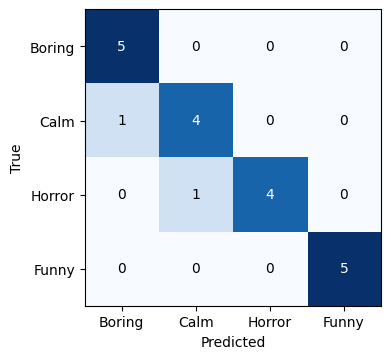

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, numpy as np
model.eval(); y_t,y_p=[],[]
with torch.no_grad():
    for x,y in test_loader:
        y_p.extend(model(x.to(device)).argmax(1).cpu().numpy())
        y_t.extend(y.numpy())
classes=['Boring','Calm','Horror','Funny']
print(classification_report(y_t,y_p,target_names=classes))
cm=confusion_matrix(y_t,y_p)
fig,ax=plt.subplots(figsize=(4,4))
ax.imshow(cm,cmap='Blues')
ax.set_xticks(range(4)); ax.set_yticks(range(4))
ax.set_xticklabels(classes); ax.set_yticklabels(classes)
for i in range(4):
    for j in range(4):
        ax.text(j,i,cm[i,j],ha='center',va='center',
                color='white' if cm[i,j]>cm.max()/2 else 'black')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
plt.tight_layout(); plt.show()

## References
- MSDCGTNet (Cheng et al., 2024)
- GAMEEMO dataset on Kaggle